In [6]:
import gym
import numpy as np
import tensorflow as tf
import frozen_lake as fl
import frozen_lake_rewards as fl_r
import frozen_lake_rewards_v2 as fl_rv2
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from six import StringIO, b
from gym.envs.toy_text import discrete
import plotting
import time
%matplotlib inline
matplotlib.style.use('ggplot')

In [7]:
"""
Solving FrozenLake8x8 environment using Value-Itertion.
Credits : Moustafa Alzantot (malzantot@ucla.edu)
"""
import numpy as np
import gym
from gym import wrappers

def run_episode(env, policy, gamma, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma,  n = 500):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    scores = [
            run_episode(env, policy, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

def extract_policy(v, gamma):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for next_sr in env.P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy


def value_iteration(env, gamma):
    """ Value-iteration algorithm """
    v = np.zeros(env.observation_space.n)  # initialize value-function
    max_iterations = 100000
    eps = 1e-5
    value_differences = []
    iteration_rewards = []
    iteration_time_differences = []
    run_time_elapsed = []
    
    run_start_time = time.time()
    
    for i in range(max_iterations):
        iteration_start_time = time.time()
        prev_v = np.copy(v)
        
        for s in range(env.observation_space.n):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.action_space.n)] 
            v[s] = max(q_sa)
        
        iteration_end_time = time.time()
        iteration_time_taken = (iteration_end_time - iteration_start_time)

        value_differences.append(np.sum(np.fabs(prev_v - v)))
        iteration_time_differences.append(iteration_time_taken)
        run_time_elapsed.append(iteration_end_time - run_start_time)
        #print(i)
        
        if i%1 == 0:
            current_policy = extract_policy(v, gamma)
            current_policy_score = evaluate_policy(env, current_policy, gamma, n=100)
            iteration_rewards.append([i,current_policy_score])
            #print(current_policy_score)
            
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            print ('Value-iteration converged at iteration# %d.' %(i+1))
            break
    return v, value_differences, iteration_rewards, iteration_time_differences, run_time_elapsed

In [8]:
"""
Solving FrozenLake8x8 environment using Policy iteration.
Credits : Moustafa Alzantot (malzantot@ucla.edu)
"""
import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma = 1.0, render = False):
    """ Runs an episode and return the total reward """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(np.argmax(policy[obs])))
        #total_reward += (gamma ** step_idx * reward)
        total_reward += reward
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma = 1.0, n = 500):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)

def extract_policy(v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma=1.0):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.observation_space.n)
    eps = 1e-10
    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
    return v

def policy_iteration(env, gamma = 1.0):
    np.random.seed(10)
    """ Policy-Iteration algorithm """
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))  # initialize a random policy
    max_iterations = 200000
    
    policy_differences = []
    iteration_rewards = []
    iteration_time_differences = []
    run_time_elapsed =[]
    
    run_start_time = time.time()
    
    
    for i in range(max_iterations):
        iteration_start_time = time.time()
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        old_scores = evaluate_policy(env, old_policy_v, gamma)
        new_scores = evaluate_policy(env, new_policy, gamma)
                
        iteration_end_time = time.time()
        iteration_time_taken = (iteration_end_time - iteration_start_time)
        
        #print(np.sum(np.abs(new_policy - policy)))

        policy_differences.append(np.sum(np.abs(new_policy - policy)))
        iteration_time_differences.append(iteration_time_taken)
        run_time_elapsed.append(iteration_end_time - run_start_time)
        
        iteration_rewards.append([i,new_scores])
        #print(current_policy_score)
        
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        policy = new_policy
        
    return policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed

# Value Iteration

Value-iteration converged at iteration# 408.
('Policy average score = ', 0.811)


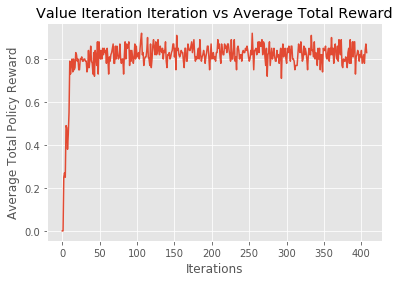

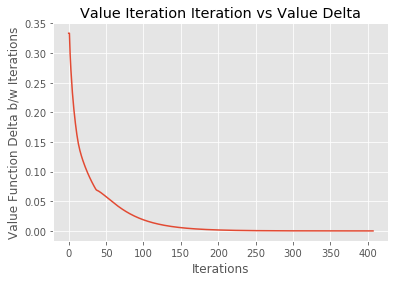

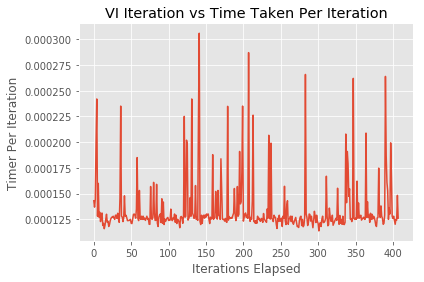

Text(0.5,1,'VI Iteration vs Total Time Taken')

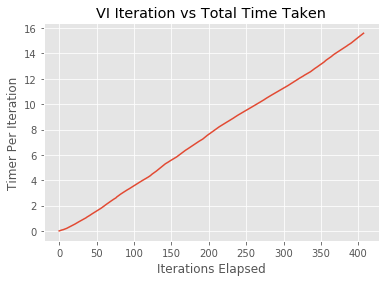

In [18]:
env = fl.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
gamma = 1
optimal_v, value_differences, iteration_rewards, iteration_time_differences, run_time_elapsed = value_iteration(env, gamma);
policy = extract_policy(optimal_v, gamma)
policy_score = evaluate_policy(env, policy, gamma, n=1000)
#print('Policy average score = ', policy_score)
print(('Policy average score = ', policy_score))

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Total Policy Reward')
plt.title('Value Iteration Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'])
plt.show()

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('Value Iteration Iteration vs Value Delta')
plt.show()

plt.plot(iteration_time_differences)
plt.xlabel('Iterations Elapsed')
plt.ylabel('Timer Per Iteration')
plt.title('VI Iteration vs Time Taken Per Iteration')
plt.show()

plt.plot(run_time_elapsed)
plt.xlabel('Iterations Elapsed')
plt.ylabel('Timer Per Iteration')
plt.title('VI Iteration vs Total Time Taken')

Value-iteration converged at iteration# 3278.
('Policy average score = ', 0.207)


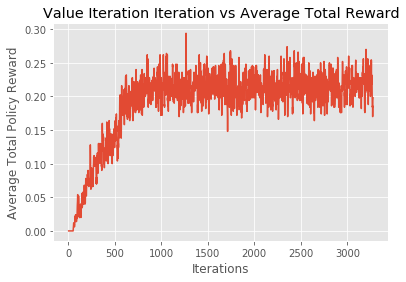

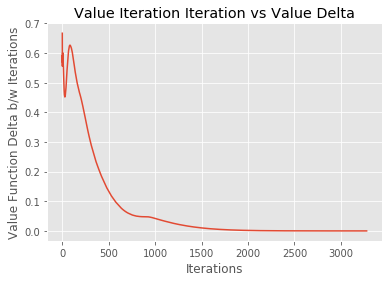

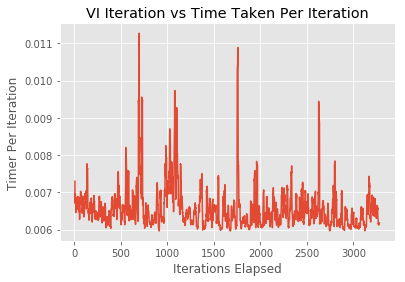

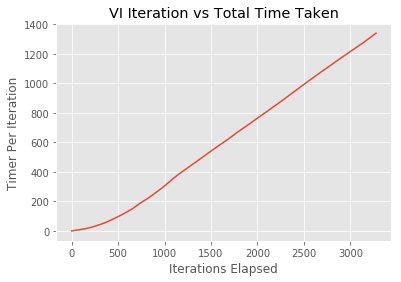

In [19]:
env = fl.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
gamma = 1.0
optimal_v, value_differences, iteration_rewards, iteration_time_differences, run_time_elapsed = value_iteration(env, gamma);
policy = extract_policy(optimal_v, gamma)
policy_score = evaluate_policy(env, policy, gamma, n=1000)
#print('Policy average score = ', policy_score)
print(('Policy average score = ', policy_score))

iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
iteration_rewards.set_index('Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Total Policy Reward')
plt.title('Value Iteration Iteration vs Average Total Reward')
plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'].rolling(5).mean())
plt.show()

plt.plot(value_differences)
plt.xlabel('Iterations')
plt.ylabel('Value Function Delta b/w Iterations')
plt.title('Value Iteration Iteration vs Value Delta')
plt.show()

plt.plot(pd.DataFrame(iteration_time_differences).rolling(10).mean())
plt.xlabel('Iterations Elapsed')
plt.ylabel('Timer Per Iteration')
plt.title('VI Iteration vs Time Taken Per Iteration')
plt.show()

plt.plot(run_time_elapsed)
plt.xlabel('Iterations Elapsed')
plt.ylabel('Timer Per Iteration')
plt.title('VI Iteration vs Total Time Taken')
plt.show()

# Policy Iteration

Gamma: 0.1
Policy-Iteration converged at step 5.
Average scores =  6.255800970271139e-08


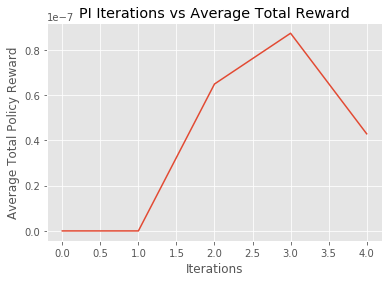

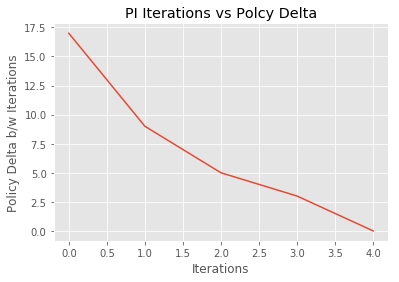

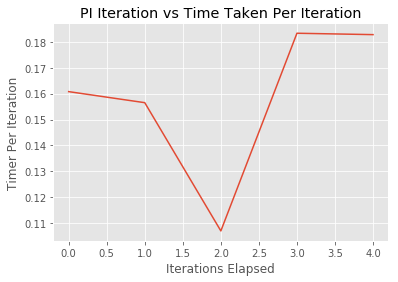

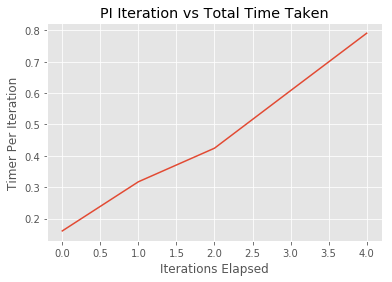

Gamma: 0.3
Policy-Iteration converged at step 5.
Average scores =  1.4316693046914337e-05


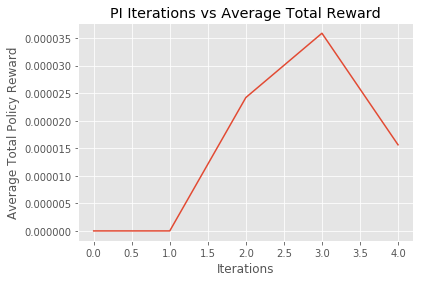

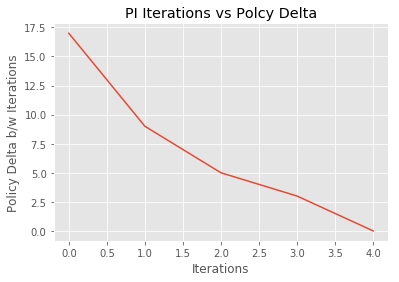

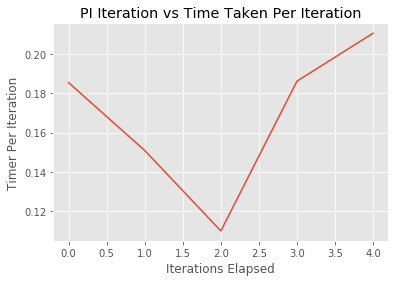

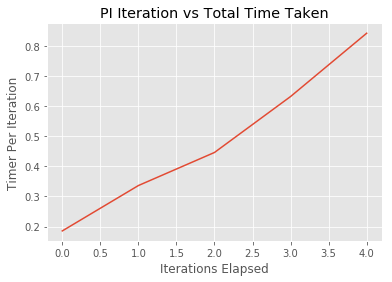

Gamma: 0.5
Policy-Iteration converged at step 5.
Average scores =  0.0007008640211417196


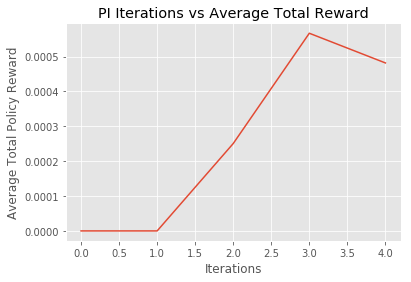

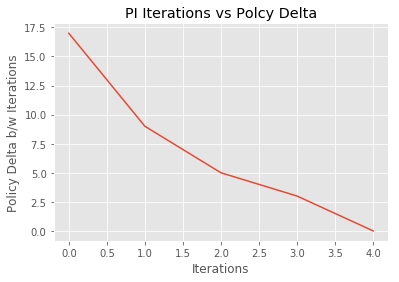

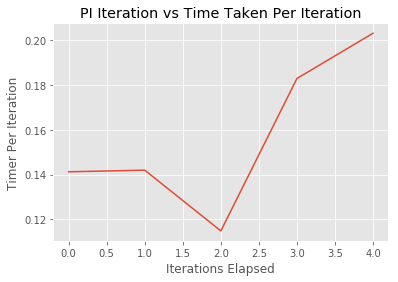

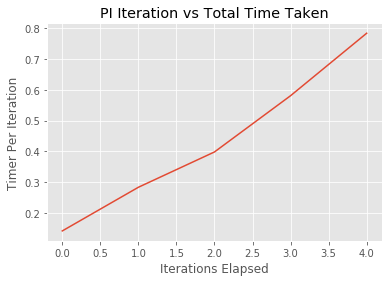

Gamma: 0.7
Policy-Iteration converged at step 5.
Average scores =  0.0037939429294441213


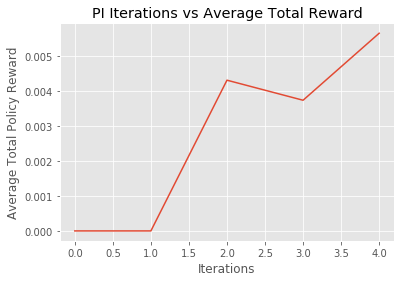

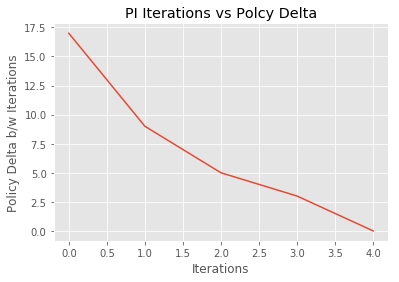

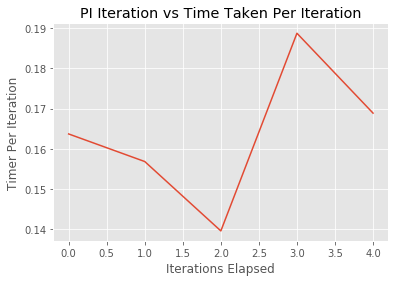

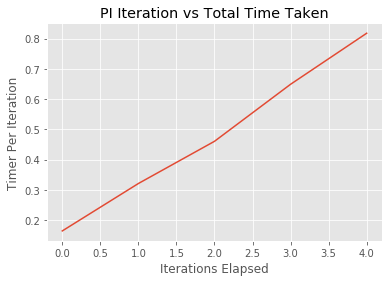

Gamma: 0.9
Policy-Iteration converged at step 6.
Average scores =  0.07368833608256943


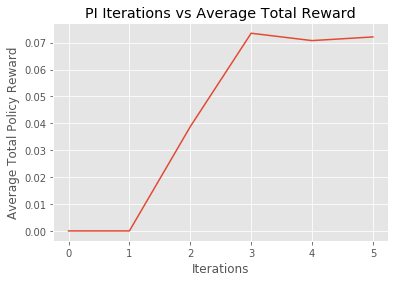

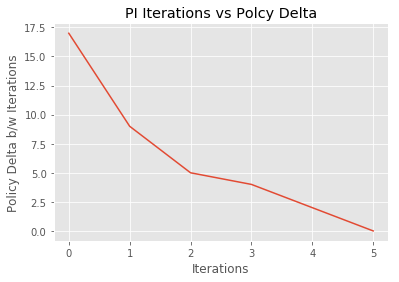

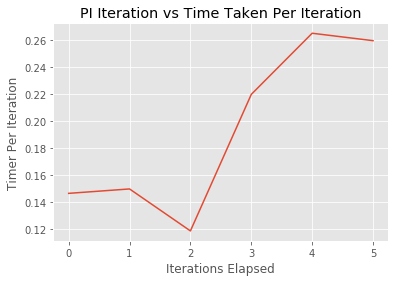

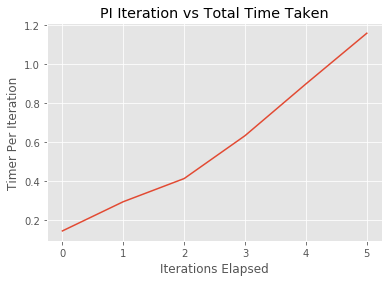

Gamma: 0.95
Policy-Iteration converged at step 6.
Average scores =  0.1757432818890577


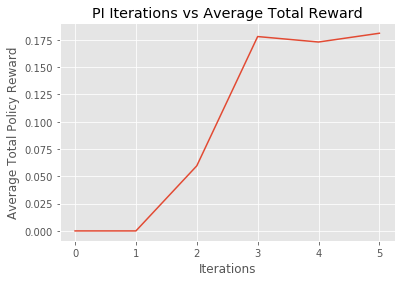

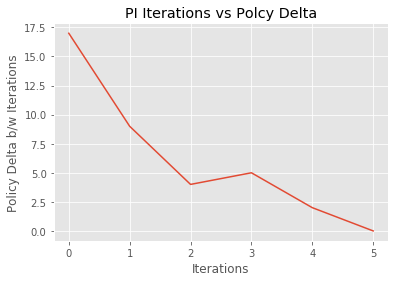

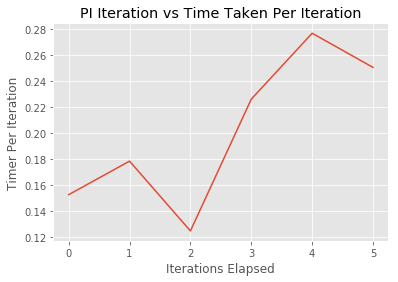

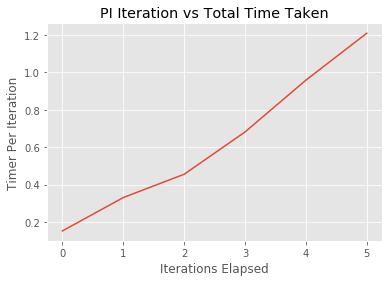

Gamma: 1.0
Policy-Iteration converged at step 7.
Average scores =  0.828


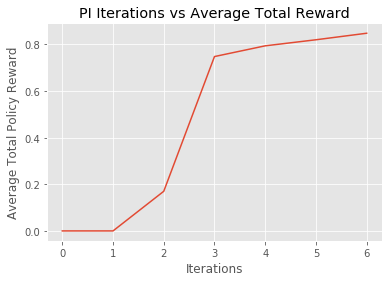

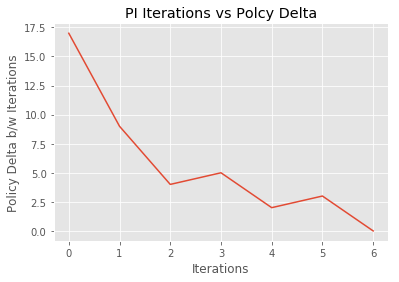

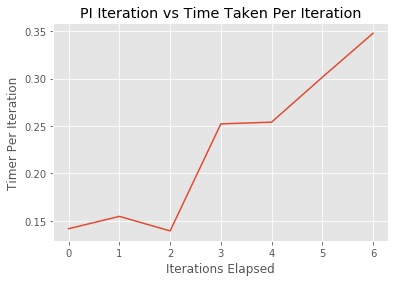

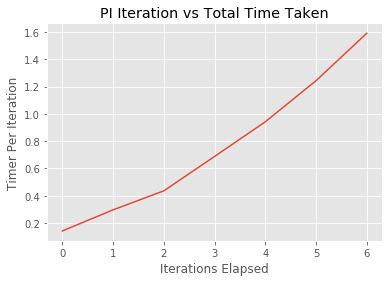

In [20]:
gamma_list = [0.1,0.3,0.5,0.7,0.9,0.95,1.0]
for g in gamma_list:
    print('Gamma: ' + str(g))
    env = fl.FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
    optimal_policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed = policy_iteration(env, gamma = g)
    scores = evaluate_policy(env, optimal_policy, gamma = g)
    print('Average scores = ', np.mean(scores))

    iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
    iteration_rewards.set_index('Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Average Total Policy Reward')
    plt.title('PI Iterations vs Average Total Reward')
    plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'])
    plt.show()

    plt.plot(policy_differences)
    plt.xlabel('Iterations')
    plt.ylabel('Policy Delta b/w Iterations')
    plt.title('PI Iterations vs Polcy Delta')
    plt.show()

    plt.plot(pd.DataFrame(iteration_time_differences))
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Time Taken Per Iteration')
    plt.show()

    plt.plot(run_time_elapsed)
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Total Time Taken')
    plt.show()

Gamma: 0.1
Policy-Iteration converged at step 4.
Average scores =  0.0


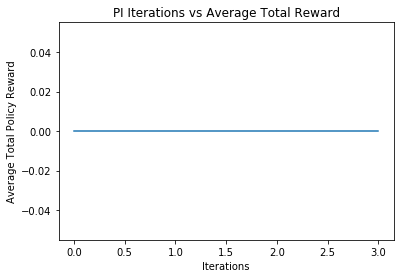

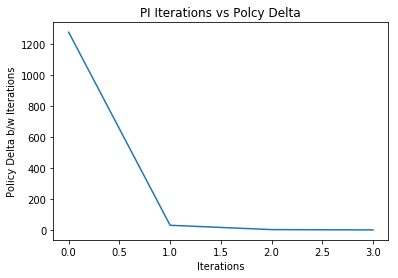

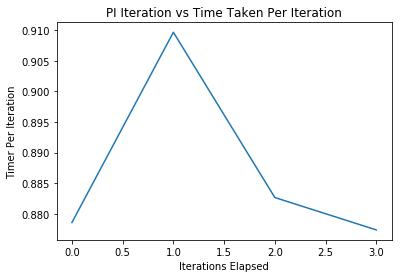

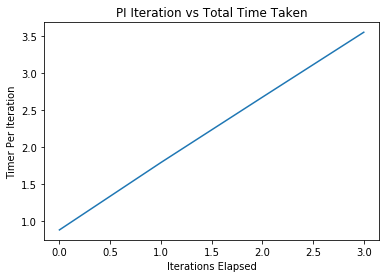

Gamma: 0.3
Policy-Iteration converged at step 5.
Average scores =  0.0


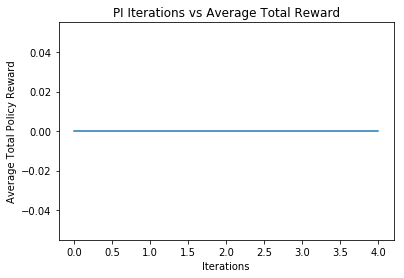

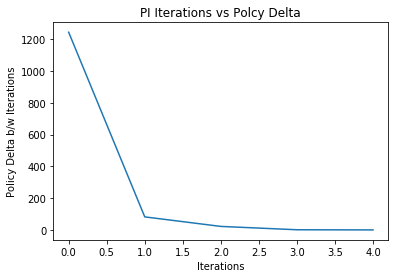

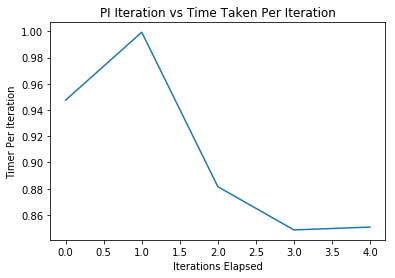

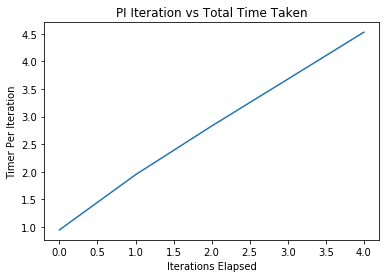

Gamma: 0.5
Policy-Iteration converged at step 10.
Average scores =  0.0


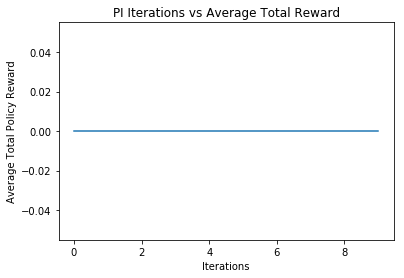

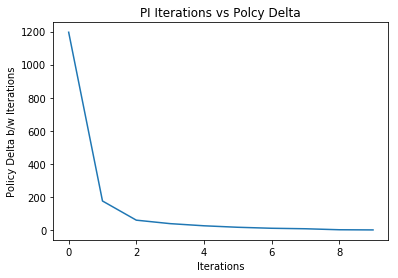

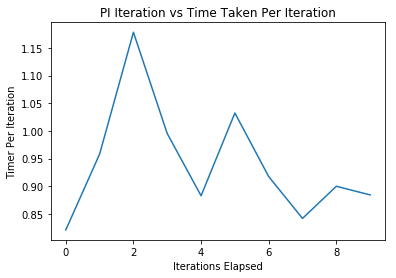

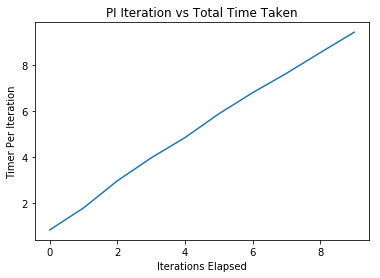

Gamma: 0.7
Policy-Iteration converged at step 10.
Average scores =  0.004


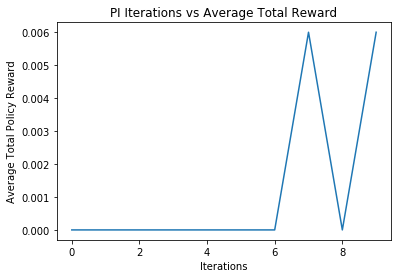

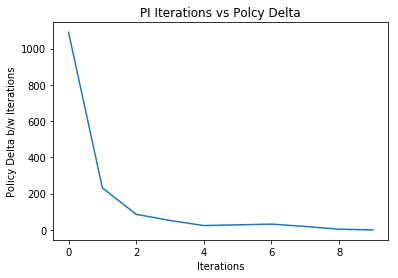

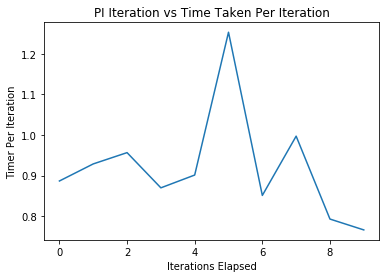

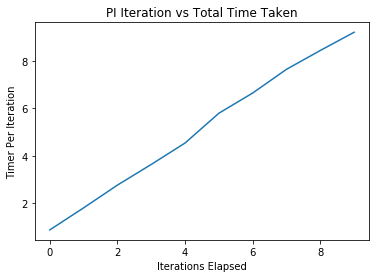

Gamma: 0.9
Policy-Iteration converged at step 5.
Average scores =  0.012


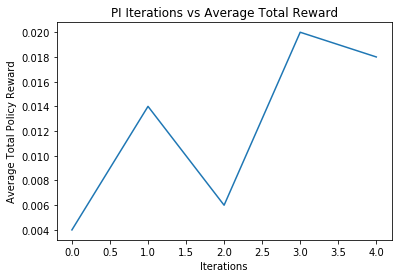

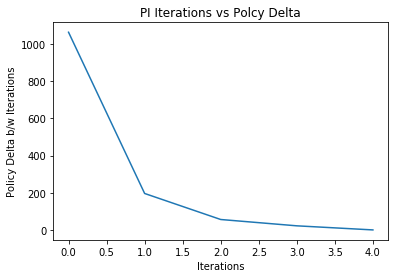

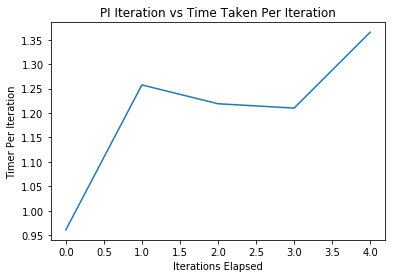

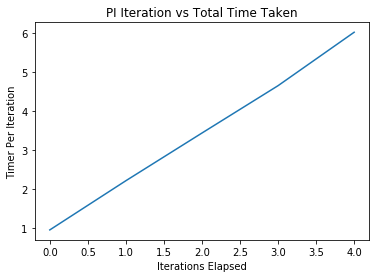

Gamma: 0.95
Policy-Iteration converged at step 7.
Average scores =  0.032


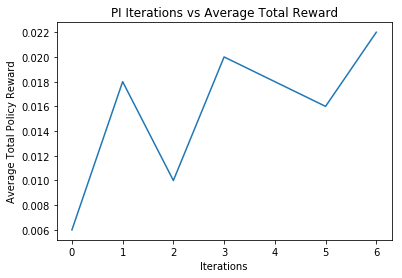

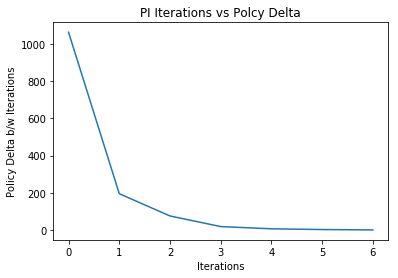

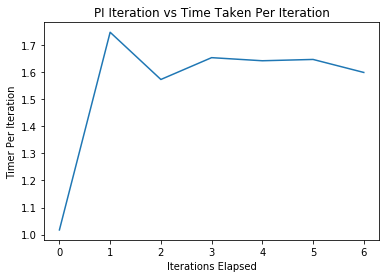

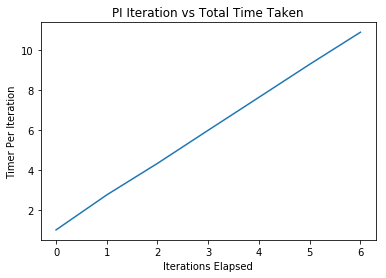

Gamma: 1.0
Policy-Iteration converged at step 11.
Average scores =  0.224


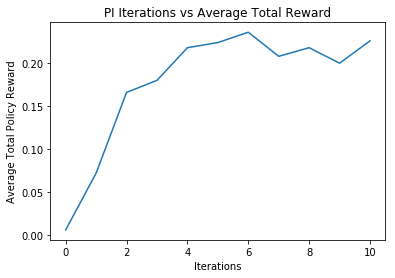

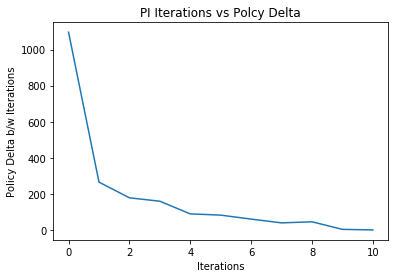

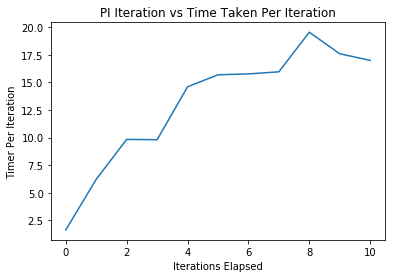

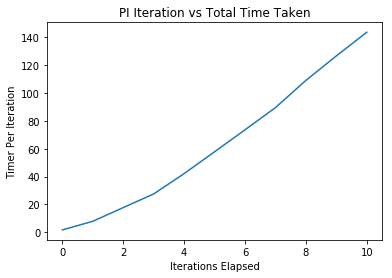

In [44]:
gamma_list = [0.1,0.3,0.5,0.7,0.9,0.95,1.0]
for g in gamma_list:
    print('Gamma: ' + str(g))
    env = fl.FrozenLakeEnv(desc=None, map_name="22x40",is_slippery=True)
    optimal_policy, policy_differences, iteration_rewards, iteration_time_differences, run_time_elapsed = policy_iteration(env, gamma = g)
    scores = evaluate_policy(env, optimal_policy, gamma = g)
    print('Average scores = ', np.mean(scores))

    iteration_rewards = pd.DataFrame(iteration_rewards, columns = ['Iteration','Average Total Policy Reward'])
    iteration_rewards.set_index('Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Average Total Policy Reward')
    plt.title('PI Iterations vs Average Total Reward')
    plt.plot(iteration_rewards['Iteration'],iteration_rewards['Average Total Policy Reward'])
    plt.show()

    plt.plot(policy_differences)
    plt.xlabel('Iterations')
    plt.ylabel('Policy Delta b/w Iterations')
    plt.title('PI Iterations vs Polcy Delta')
    plt.show()

    plt.plot(pd.DataFrame(iteration_time_differences))
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Time Taken Per Iteration')
    plt.show()

    plt.plot(run_time_elapsed)
    plt.xlabel('Iterations Elapsed')
    plt.ylabel('Timer Per Iteration')
    plt.title('PI Iteration vs Total Time Taken')
    plt.show()